In [1]:
import glob
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop

In [2]:
os.chdir('data')
test_paths = sorted(glob.glob('./test_imgs/*.jpg'))

In [3]:
base_model = MobileNetV3Small(
    input_shape=(270, 480, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    dropout_rate=0.8
)

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(48)(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=RMSprop(
        learning_rate=0.1,
        momentum=0.9
    ),
    loss='mean_squared_error',
    metrics=['accuracy'])

In [4]:
model.load_weights("210326_aug_mobilenetv3small_01_62.h5")

In [5]:
X_test = []

for test_path in tqdm(test_paths):
    img = tf.io.read_file(test_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [270, 480])
    img = img/255
    X_test.append(img)

X_test = tf.stack(X_test, axis=0)
X_test.shape

100%|██████████| 1600/1600 [00:16<00:00, 96.31it/s] 


TensorShape([1600, 270, 480, 3])

In [6]:
pred = model.predict(X_test)

In [7]:
submission = pd.read_csv('./sample_submission.csv')
# image size를 1920x1080 -> 480x270으로 바꿔서 예측했으므로 * 4
submission.iloc[:, 1:] = pred*4

In [8]:
# submission
submission.to_csv('submission_210326_aug_mobilenetv3small_01_62.csv', index=False)

In [9]:
import random
from PIL import Image
import matplotlib.pyplot as plt

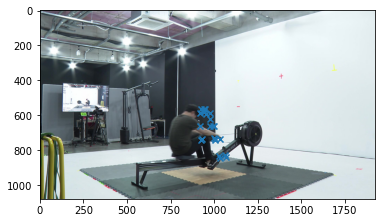

In [10]:
n = random.randint(0, 1600)
predicted_keypoint = submission.iloc[n, 1:49]
predicted_keypoint = np.array(predicted_keypoint)
img = Image.open(test_paths[n])
plt.imshow(img)
plt.scatter(predicted_keypoint[0::2], predicted_keypoint[1::2], marker='x')